In [ ]:
!pip install -U scipy scikit-learn catboost shap seaborn matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import shap

In [ ]:
SPRIMARY = "#FFDD2D"
SBASE_01 = "#F5F5F8"
SBASE_02 = "#333333"
SBASE_03 = "#FFFFFF"
SACCENT = "#FFDD2D"

sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.facecolor": SBASE_03,
    "figure.facecolor": SBASE_03,
    "grid.color": "#E0E0E0",
    "axes.edgecolor": SBASE_02,
    "axes.labelcolor": SBASE_02,
    "xtick.color": SBASE_02,
    "ytick.color": SBASE_02,
    "text.color": SBASE_02,
    "font.family": "sans-serif",

    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlecolor": SBASE_02,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,

    "grid.linewidth": 0.8,
    "grid.alpha": 0.3,
    "axes.linewidth": 1.2,
    "lines.linewidth": 2.5,
})

brand_palette = [SACCENT, SPRIMARY, "#FF8E29", "#2ACA80", "#A56EFF"]
sns.set_palette(brand_palette)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Копия clustered_clients_clean.csv', index_col=['key'])

In [ ]:
df = df1.copy().drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

In [ ]:
threshold = 8

for column in df.columns:
    if not pd.api.types.is_categorical_dtype(df[column]) and not pd.api.types.is_datetime64_any_dtype(df[column]):
        unique_count = df[column].nunique()

        if unique_count < threshold:
            df[column] = df[column].astype('category')

<ipython-input-197-175383a0c94c>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]) and not pd.api.types.is_datetime64_any_dtype(df[column]):


In [ ]:
TARGET_COLUMN = 'target_x'

In [ ]:
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

cat_features = list(X.select_dtypes(include=['object', 'category', 'bool']).columns)
num_features = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [ ]:
for col in cat_features:
    mode = X[col].mode()[0]
    X[col] = X[col].fillna(mode)

for col in num_features:
    median = X[col].median()
    X[col] = X[col].fillna(median)
    df[col] = X[col]

In [ ]:
df[TARGET_COLUMN] = np.int64(df[TARGET_COLUMN])

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_feature(feature, target, feature_name, feature_type):
    valid_idx = feature.notna() & target.notna()
    feature_clean = feature[valid_idx]
    target_clean = target[valid_idx]

    results = {
        'feature': feature_name,
        'type': feature_type,
        'n_total': len(feature_clean),
        'n_class0': (target_clean == 0).sum(),
        'n_class1': (target_clean == 1).sum(),
        'test': None,
        'pvalue': None,
        'effect_size': None,
        'interpretation': None
    }

    if results['n_class0'] < 3 or results['n_class1'] < 3:
        results['interpretation'] = "Недостаточно данных для статистического теста"
        return results

    if feature_type == 'categorical':
        value_counts = feature_clean.value_counts()
        small_categories = value_counts[value_counts < len(feature_clean)*0.05].index
        feature_agg = feature_clean.replace(small_categories, 'Other')
        n_categories = feature_agg.nunique()

        is_binary = n_categories == 2

        contingency_table = pd.crosstab(feature_agg, target_clean)

        if contingency_table.size == 0 or contingency_table.sum().sum() == 0:
            results['interpretation'] = "Нет данных для анализа (пустая таблица сопряженности)"
            return results

        if is_binary:
            try:
                _, p_value = stats.fisher_exact(contingency_table)
                test_name = "Тест Фишера"

                a, b = contingency_table.iloc[0,0], contingency_table.iloc[0,1]
                c, d = contingency_table.iloc[1,0], contingency_table.iloc[1,1]

                if b == 0 or c == 0 or d == 0:
                    odds_ratio = (a * d) / (1 if (b * c) == 0 else (b * c))
                    effect_size = f"OR ≈ {odds_ratio:.2f} (adjusted)"
                else:
                    odds_ratio = (a * d) / (b * c)
                    effect_size = f"OR = {odds_ratio:.2f}"
            except ValueError:
                _, p_value, _, _ = stats.chi2_contingency(contingency_table)
                test_name = "Chi-square Test (fallback)"
                effect_size = "N/A"
        else:
            if contingency_table.size > 0:
                try:
                    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                    test_name = "Хи-квадрат"

                    n = contingency_table.sum().sum()
                    min_dim = min(contingency_table.shape) - 1
                    cramers_v = np.sqrt(chi2 / (n * min_dim)) if n * min_dim > 0 else 0
                    effect_size = f"Cramer's V = {cramers_v:.2f}"
                except ValueError:
                    p_value = 1.0
                    test_name = "Test skipped"
                    effect_size = "N/A"
            else:
                p_value = 1.0
                test_name = "No test"
                effect_size = "N/A"

        results['test'] = test_name
        results['pvalue'] = p_value
        results['effect_size'] = effect_size
        results['n_categories'] = n_categories

    else:
        group0 = feature_clean[target_clean == 0]
        group1 = feature_clean[target_clean == 1]

        if len(group0) == 0 or len(group1) == 0:
            results['interpretation'] = "Одна из групп не содержит данных"
            return results

        normal_test = True
        if len(group0) >= 5 and len(group1) >= 5:
            try:
                _, p_normal0 = stats.shapiro(group0)
                _, p_normal1 = stats.shapiro(group1)
                normal_test = (p_normal0 > 0.05) and (p_normal1 > 0.05)
            except:
                normal_test = False

        if normal_test:
            try:
                _, p_value = stats.ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
                test_name = "Welch's t-test"

                std0, std1 = group0.std(), group1.std()
                if std0 == 0 and std1 == 0:
                    cohens_d = 0.0
                else:
                    pooled_std = np.sqrt((std0**2 + std1**2) / 2)
                    cohens_d = (group1.mean() - group0.mean()) / (pooled_std if pooled_std > 0 else 1)

                effect_size = f"Cohen's d = {cohens_d:.2f}"
            except:
                p_value = 1.0
                test_name = "t-test failed"
                effect_size = "N/A"
        else:
            try:
                _, p_value = stats.mannwhitneyu(group0, group1, alternative='two-sided', nan_policy='omit')
                test_name = "Манн-Уитни"

                u_stat = stats.mannwhitneyu(group0, group1, alternative='two-sided').statistic
                n0, n1 = len(group0), len(group1)
                rank_biserial = 1 - (2 * u_stat) / (n0 * n1) if n0 * n1 > 0 else 0
                effect_size = f"Rank-biserial r = {rank_biserial:.2f}"
            except:
                p_value = 1.0
                test_name = "U-test failed"
                effect_size = "N/A"

        results['test'] = test_name
        results['pvalue'] = p_value
        results['effect_size'] = effect_size
        results['mean_class0'] = group0.mean() if len(group0) > 0 else np.nan
        results['mean_class1'] = group1.mean() if len(group1) > 0 else np.nan

    p_val = results['pvalue'] if results['pvalue'] is not None else 1.0

    if p_val < 0.01:
        results['interpretation'] = "Очень сильная связь с целевой переменной (p < 0.01)"
    elif p_val < 0.05:
        results['interpretation'] = "Статистически значимая связь (p < 0.05)"
    elif p_val < 0.1:
        results['interpretation'] = "Слабая связь (p < 0.1)"
    else:
        results['interpretation'] = "Нет статистически значимой связи"

    return results

In [ ]:
results = []
for col in X.columns:
    feature_type = 'categorical' if col in cat_features else 'numerical'

    res = analyze_feature(X[col], y, col, feature_type)
    results.append(res)

    print(f"\n{'-'*60}")
    print(f"Признак: {res['feature']}")
    print(f"Тип: {res['type']}")
    print(f"Всего наблюдений: {res['n_total']} (Class 0: {res['n_class0']}, Class 1: {res['n_class1']})")

    if 'n_categories' in res:
        print(f"Уникальных категорий: {res['n_categories']}")

    if res['test']:
        print(f"Статистический тест: {res['test']}")
        print(f"p-value: {res['pvalue']:.4e}")
        print(f"Размер эффекта: {res['effect_size']}")

        if res['type'] == 'numerical':
            print(f"Среднее Class 0: {res['mean_class0']:.4f}, Class 1: {res['mean_class1']:.4f}")

    print(f"Интерпретация: {res['interpretation']}")
    print(f"{'-'*60}")

results_df = pd.DataFrame(results)
print("\nСводная таблица результатов:")
print(results_df[['feature', 'type', 'test', 'pvalue', 'interpretation']])


------------------------------------------------------------
Признак: expiration_minus_1d_dt
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 1
Статистический тест: Хи-квадрат
p-value: 1.0000e+00
Размер эффекта: Cramer's V = 0.00
Интерпретация: Нет статистически значимой связи
------------------------------------------------------------

------------------------------------------------------------
Признак: Poluchaet_ZP_x
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 1.0435e-01
Размер эффекта: OR = 0.84
Интерпретация: Нет статистически значимой связи
------------------------------------------------------------

------------------------------------------------------------
Признак: Oplata_SBP_po_QR_x
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 7.1903e-02
Раз

<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12088.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
/usr/local/lib/python3.11/dist-packages/scipy/stats/


------------------------------------------------------------
Признак: Deneg_bolee_100tys
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 5.2478e-05
Размер эффекта: OR = 0.65
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: Traty_bolee_10tys
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 5.1308e-21
Размер эффекта: OR = 0.66
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: IFL
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value:

<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_ca


------------------------------------------------------------
Признак: Avtoplatezh
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 7.1551e-02
Размер эффекта: OR = 0.81
Интерпретация: Слабая связь (p < 0.1)
------------------------------------------------------------

------------------------------------------------------------
Признак: LifeStyle
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 7.1759e-02
Размер эффекта: OR = 0.88
Интерпретация: Слабая связь (p < 0.1)
------------------------------------------------------------

------------------------------------------------------------
Признак: Dopka_na_3_litso
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 6.4258e-01
Размер эффекта: OR = 0.94
Интерпретация: Нет ста

<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')



------------------------------------------------------------
Признак: Est'_mobajl
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 9.0856e-04
Размер эффекта: OR = 0.80
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: Investkopilka
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 7.1563e-03
Размер эффекта: OR = 0.85
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: Taksi
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 1.8589e-

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12088.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')



------------------------------------------------------------
Признак: avg_out_request_cnt
Тип: numerical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Статистический тест: Манн-Уитни
p-value: 2.0415e-04
Размер эффекта: Rank-biserial r = 0.05
Среднее Class 0: 0.0850, Class 1: 0.1687
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: ipl_perc
Тип: numerical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Статистический тест: Манн-Уитни
p-value: 7.0734e-01
Размер эффекта: Rank-biserial r = 0.00
Среднее Class 0: 0.0959, Class 1: 0.0749
Интерпретация: Нет статистически значимой связи
------------------------------------------------------------

------------------------------------------------------------
Признак: log_p_q_av
Тип: numerical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Статистический тест: Манн-Уитни
p

<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_ca


------------------------------------------------------------
Признак: Pro
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 4.2422e-26
Размер эффекта: OR = 0.62
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: Nakopitel'nyj_schet
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value: 6.8119e-05
Размер эффекта: OR = 0.84
Интерпретация: Очень сильная связь с целевой переменной (p < 0.01)
------------------------------------------------------------

------------------------------------------------------------
Признак: Brokerskij_schet
Тип: categorical
Всего наблюдений: 14756 (Class 0: 12088, Class 1: 2668)
Уникальных категорий: 2
Статистический тест: Тест Фишера
p-value:

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12088.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')
<ipython-input-173-93752f5cf1c6>:29: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  feature_agg = feature_clean.replace(small_categories, 'Other')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
import torch
import matplotlib.pyplot as plt
import seaborn as sns

cols_for_process = [col for col in X.columns if X[col].dtype != 'object']
X_processed = X[cols_for_process].copy()

cat_features_names = [col for col in X_processed.columns
                      if X_processed[col].nunique() < 8]

date_cols = [col for col in X_processed.columns if 'dt' in col or 'date' in col]
for col in date_cols:
    try:
        X_processed[col] = pd.to_datetime(X_processed[col])
        X_processed[f'{col}_year'] = X_processed[col].dt.year
        X_processed[f'{col}_month'] = X_processed[col].dt.month
        X_processed[f'{col}_day'] = X_processed[col].dt.day
        X_processed[f'{col}_dow'] = X_processed[col].dt.dayofweek
        X_processed = X_processed.drop(columns=[col])
    except:
        pass

cat_features_names = [col for col in X_processed.columns
                      if (X_processed[col].nunique() < 8) and
                         (col not in date_cols)]

for col in cat_features_names:
    X_processed[col] = X_processed[col].apply(lambda x: str(x) if pd.notnull(x) else 'MISSING')
    counts = X_processed[col].value_counts()
    rare_categories = counts[counts < 5].index
    X_processed[col] = X_processed[col].apply(lambda x: 'RARE' if x in rare_categories else x)

if 'feature1' in X_processed and 'feature2' in X_processed:
    X_processed['feature1_feature2_ratio'] = X_processed['feature1'] / (X_processed['feature2'] + 1e-6)
    X_processed['feature1_feature2_sum'] = X_processed['feature1'] + X_processed['feature2']

if 'important_feature' in X_processed:
    X_processed['important_feature_sq'] = X_processed['important_feature'] ** 2
    X_processed['important_feature_log'] = np.log1p(np.abs(X_processed['important_feature']))


In [ ]:
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

class_weights = len(y_train) / (2 * np.bincount(y_train))
scale_pos_weight = class_weights[1] / class_weights[0]

fixed_params = {
    'iterations': 2000,
    'verbose': False,
    'early_stopping_rounds': 100,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'bootstrap_type': 'Bayesian',
    'grow_policy': 'Lossguide',
    'random_strength': 1,
    'border_count': 254
}

param_grid = {
    'learning_rate': [0.03],
    'l2_leaf_reg': [6],
    'max_leaves': [32]
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(**fixed_params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train,
                cat_features=cat_features_names)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший AUC: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры: {'l2_leaf_reg': 6, 'learning_rate': 0.03, 'max_leaves': 32}
Лучший AUC: 0.6597


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6026320	best: 0.6026320 (0)	total: 192ms	remaining: 6m 24s
100:	test: 0.6510850	best: 0.6510850 (100)	total: 17.8s	remaining: 5m 34s
200:	test: 0.6593134	best: 0.6593557 (199)	total: 35.2s	remaining: 5m 14s
300:	test: 0.6631578	best: 0.6631579 (298)	total: 54.7s	remaining: 5m 8s
400:	test: 0.6660197	best: 0.6660345 (398)	total: 1m 12s	remaining: 4m 50s
500:	test: 0.6683667	best: 0.6683667 (500)	total: 1m 33s	remaining: 4m 40s
600:	test: 0.6697126	best: 0.6697126 (600)	total: 1m 51s	remaining: 4m 20s
700:	test: 0.6709356	best: 0.6710147 (676)	total: 2m 12s	remaining: 4m 5s
800:	test: 0.6715839	best: 0.6717434 (775)	total: 2m 30s	remaining: 3m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6717434411
bestIteration = 775

Shrink model to first 776 iterations.

Топ-20 признаков:
                         Feature Id  Importances
0                         accnt_cnt    10.576131
1   median_count_of_ever_opened_cor     8.330636
2               max_out_tel_mb

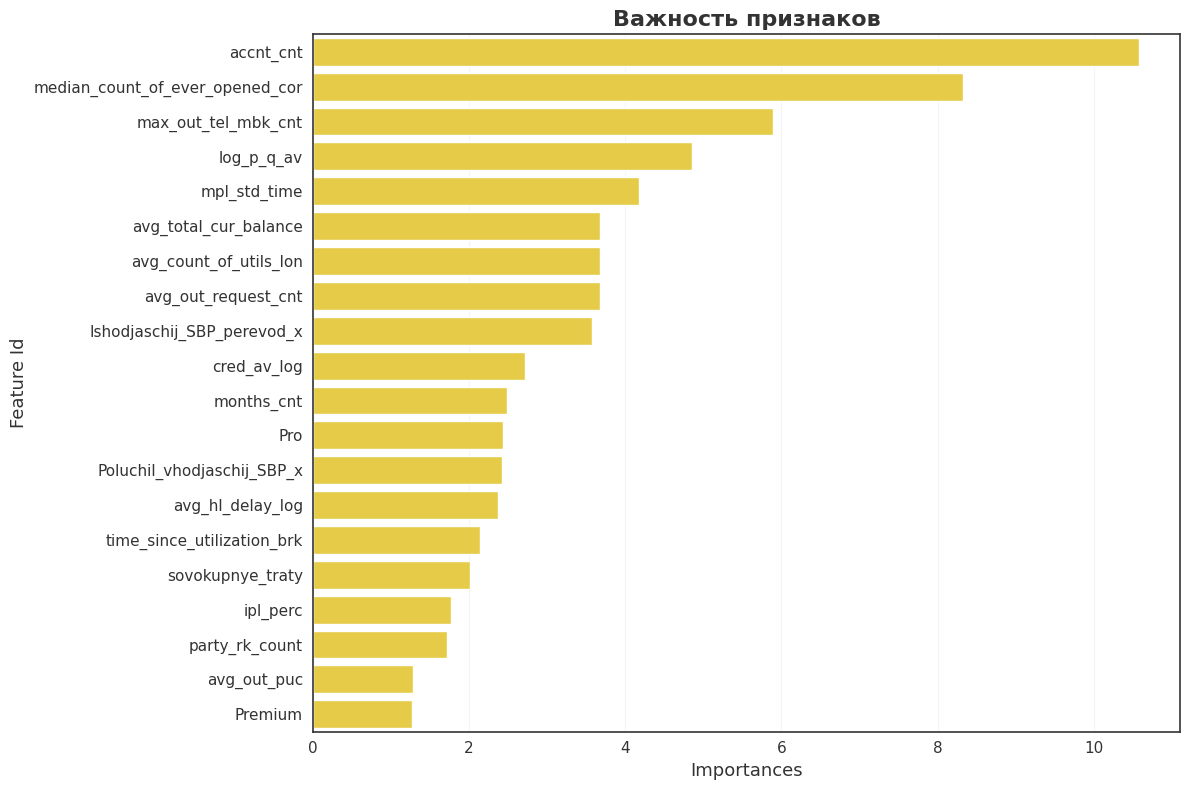

In [ ]:
final_params = {**fixed_params, **grid_search.best_params_}
final_model = CatBoostClassifier(**final_params)

train_pool = Pool(X_train, y_train, cat_features=cat_features_names)
test_pool = Pool(X_test, y_test, cat_features=cat_features_names)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    plot=True,
    use_best_model=True
)

feature_importances = final_model.get_feature_importance(prettified=True)
print("\nТоп-20 признаков:")
print(feature_importances.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(20))
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

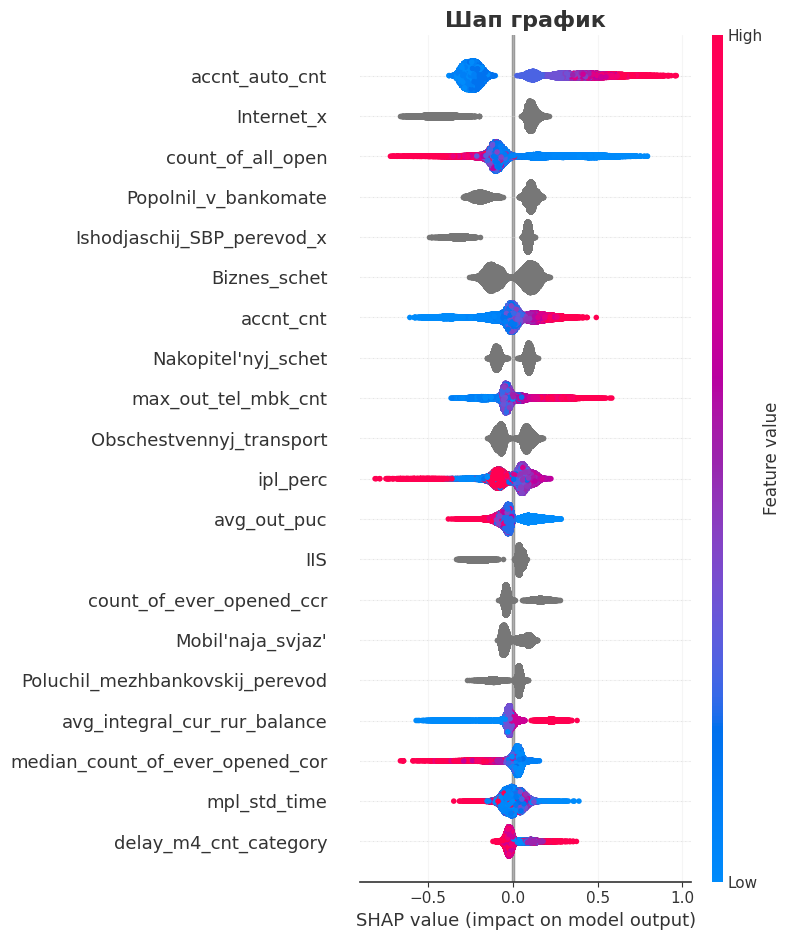

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(train_pool)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="dot", show=False)
plt.title('Шап график')
plt.tight_layout()
plt.show()


In [ ]:
stats_results = []
for res in results:
    row = {
        'Feature': res['feature'],
        'Type': res['type'].capitalize(),
        'Test': res['test'],
        'p-value': res['pvalue'],
        'Effect Size': res['effect_size'],
        'Interpretation': res['interpretation']
    }

    if res['type'] == 'numerical':
        row['Mean Class 0'] = res.get('mean_class0', np.nan)
        row['Mean Class 1'] = res.get('mean_class1', np.nan)
    else:
        row['Categories'] = res.get('n_categories', '-')

    stats_results.append(row)

stats_df = pd.DataFrame(stats_results)
stats_df['Significant'] = stats_df['p-value'] < 0.05

def format_pvalue(p):
    if not isinstance(p, (int, float)):
        return str(p)
    if p < 0.0001:
        return "<0.0001"
    return f"{p:.4f}"

stats_df['p-value'] = stats_df['p-value'].apply(format_pvalue)

print("\nСводная таблица статистического анализа:")
display(stats_df)


Сводная таблица статистического анализа:


,Feature,Type,Test,p-value,Effect Size,Interpretation,Categories,Mean Class 0,Mean Class 1,Significant
0,expiration_minus_1d_dt,Categorical,Хи-квадрат,1.0000,Cramer's V = 0.00,Нет статистически значимой связи,1.0,NaN,NaN,False
1,Poluchaet_ZP_x,Categorical,Тест Фишера,0.1043,OR = 0.84,Нет статистически значимой связи,2.0,NaN,NaN,False
2,Oplata_SBP_po_QR_x,Categorical,Тест Фишера,0.0719,OR = 0.91,Слабая связь (p < 0.1),2.0,NaN,NaN,False
3,Internet_x,Categorical,Тест Фишера,0.0003,OR = 0.74,Очень сильная связь с целевой переменной (p < ...,2.0,NaN,NaN,True
4,Ishodjaschij_SBP_perevod_x,Categorical,Тест Фишера,<0.0001,OR = 1.43,Очень сильная связь с целевой переменной (p < ...,2.0,NaN,NaN,True
5,Poluchil_vhodjaschij_SBP_x,Categorical,Тест Фишера,<0.0001,OR = 1.25,Очень сильная связь с целевой переменной (p < ...,2.0,NaN,NaN,True
6,credit_class_x,Categorical,Хи-квадрат,<0.0001,Cramer's V = 0.05,Очень сильная связь с целевой переменной (p < ...,3.0,NaN,NaN,True
7,avg_hl_delay_log,Numerical,Манн-Уитни,0.8836,Rank-biserial r = 0.00,Нет статистически значимой связи,NaN,0.625421,0.625748,False
8,cred_av_log,Numerical,Манн-Уитни,0.1748,Rank-biserial r = 0.02,Нет статистически значимой связи,NaN,0.312807,0.317007,False
9,delay_m4_cnt_category,Categorical,Хи-квадрат,0.7311,Cramer's V = 0.01,Нет статистически значимой связи,3.0,NaN,NaN,False


from matplotlib import pyplot as plt
stats_df['Categories'].plot(kind='hist', bins=20, title='Categories')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats_df['Mean Class 0'].plot(kind='hist', bins=20, title='Mean Class 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats_df['Mean Class 1'].plot(kind='hist', bins=20, title='Mean Class 1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats_df.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats_df.groupby('Test').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats_df.groupby('Interpretation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats_df.groupby('Significant').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats_df.plot(kind='scatter', x='Categories', y='Mean Class 0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats_df.plot(kind='scatter', x='Mean Class 0', y='Mean Class 1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats_df['Categories'].plot(kind='line', figsize=(8, 4), title='Categories')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats_df['Mean Class 0'].plot(kind='line', figsize=(8, 4), title='Mean Class 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats_df['Mean Class 1'].plot(kind='line', figsize=(8, 4), title='Mean Class 1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Test'].value_counts()
    for x_label, grp in stats_df.groupby('Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Type')
_ = plt.ylabel('Test')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Interpretation'].value_counts()
    for x_label, grp in stats_df.groupby('Test')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Test')
_ = plt.ylabel('Interpretation')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Significant'].value_counts()
    for x_label, grp in stats_df.groupby('Interpretation')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Interpretation')
_ = plt.ylabel('Significant')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats_df['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats_df, x='Categories', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats_df['Test'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats_df, x='Categories', y='Test', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats_df['Interpretation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats_df, x='Categories', y='Interpretation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats_df['Significant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats_df, x='Categories', y='Significant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
param_grid = { 'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10] }
cv = StratifiedKFold(n_splits=3, random_state=43, shuffle=True)

gs = GridSearchCV(rfc_model)

|index|Feature|Type|Test|p-value|Effect Size|Interpretation|Categories|Mean Class 0|Mean Class 1|Significant|
|---|---|---|---|---|---|---|---|---|---|---|
|0|expiration\_minus\_1d\_dt|Categorical|Хи-квадрат|1\.0000|Cramer's V = 0\.00|Нет статистически значимой связи|1\.0|NaN|NaN|false|
|1|Poluchaet\_ZP\_x|Categorical|Тест Фишера|0\.8863|OR = 1\.01|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|2|Oplata\_SBP\_po\_QR\_x|Categorical|Тест Фишера|\<0\.0001|OR = 0\.77|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|3|Internet\_x|Categorical|Тест Фишера|0\.0318|OR = 0\.84|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|4|Ishodjaschij\_SBP\_perevod\_x|Categorical|Тест Фишера|\<0\.0001|OR = 1\.55|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|5|Poluchil\_vhodjaschij\_SBP\_x|Categorical|Тест Фишера|\<0\.0001|OR = 1\.32|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|6|credit\_class\_x|Categorical|Хи-квадрат|\<0\.0001|Cramer's V = 0\.08|Очень сильная связь с целевой переменной \(p \< 0\.01\)|3\.0|NaN|NaN|true|
|7|avg\_hl\_delay\_log|Numerical|Манн-Уитни|0\.4684|Rank-biserial r = 0\.01|Нет статистически значимой связи|NaN|0\.6248357840707475|0\.6280722213673369|false|
|8|cred\_av\_log|Numerical|Манн-Уитни|0\.1068|Rank-biserial r = 0\.02|Нет статистически значимой связи|NaN|0\.3095608855816076|0\.31512864638160215|false|
|9|delay\_m4\_cnt\_category|Categorical|Хи-квадрат|0\.0132|Cramer's V = 0\.03|Статистически значимая связь \(p \< 0\.05\)|3\.0|NaN|NaN|true|
|10|sovokupnye\_traty|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.06|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|4\.216544362908606|3\.9864675688287448|true|
|11|avg\_integral\_cur\_rur\_balance|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.07|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|3\.525683789192795|3\.3947736817545495|true|
|12|avg\_out\_puc|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.06|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|4\.064843228819213|3\.9748016798880075|true|
|13|months\_cnt|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.07|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|0\.022722745856756356|-0\.06448028923304501|true|
|14|Deneg\_bolee\_100tys|Categorical|Тест Фишера|\<0\.0001|OR = 0\.47|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|15|Traty\_bolee\_10tys|Categorical|Тест Фишера|\<0\.0001|OR = 0\.72|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|16|IFL|Categorical|Тест Фишера|0\.4207|OR = 1\.14|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|17|Strahovanie\_ipoteki|Categorical|Тест Фишера|0\.0295|OR = 1\.38|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|18|Oteli|Categorical|Тест Фишера|0\.0956|OR = 0\.83|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|19|Kasko|Categorical|Тест Фишера|0\.5739|OR = 1\.06|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|20|Karshering|Categorical|Тест Фишера|0\.6762|OR = 0\.94|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|21|VZR|Categorical|Тест Фишера|0\.1099|OR = 0\.92|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|22|Travel|Categorical|Тест Фишера|0\.0747|OR = 0\.87|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|23|Oplatil\_toplivo\_v\_Tinkoff\_Gorod|Categorical|Тест Фишера|0\.6915|OR = 1\.03|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|24|Oplatil\_shtraf|Categorical|Тест Фишера|0\.5180|OR = 1\.06|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|25|Avtoplatezh|Categorical|Тест Фишера|0\.0605|OR = 0\.84|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|26|LifeStyle|Categorical|Тест Фишера|0\.4991|OR = 1\.04|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|27|Dopka\_na\_3\_litso|Categorical|Тест Фишера|0\.4514|OR = 0\.95|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|28|Osago|Categorical|Тест Фишера|0\.5563|OR = 0\.96|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|29|Privel\_druga|Categorical|Тест Фишера|0\.0515|OR = 1\.15|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|30|used\_special\_offer|Categorical|Тест Фишера|0\.4503|OR = 0\.96|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|31|ZhKH|Categorical|Тест Фишера|0\.0134|OR = 0\.88|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|32|Poluchil\_mezhbankovskij\_perevod|Categorical|Тест Фишера|0\.0003|OR = 1\.23|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|33|Podpiski\_na\_servisy|Categorical|Тест Фишера|\<0\.0001|OR = 0\.74|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|34|Junior|Categorical|Тест Фишера|0\.6954|OR = 0\.87|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|35|Est'\_mobajl|Categorical|Тест Фишера|0\.2782|OR = 0\.94|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|36|Investkopilka|Categorical|Тест Фишера|0\.0527|OR = 0\.90|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|37|Taksi|Categorical|Тест Фишера|0\.0015|OR = 0\.84|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|38|NS\_keptivnaja\_strahovka|Categorical|Тест Фишера|0\.3583|OR = 0\.95|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|39|Popolnil\_v\_bankomate|Categorical|Тест Фишера|0\.0228|OR = 1\.13|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|40|Zapravki|Categorical|Тест Фишера|0\.0049|OR = 0\.87|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|41|Podpiska\_na\_shtrafy|Categorical|Тест Фишера|0\.0435|OR = 1\.11|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|42|Perevod\_po\_telefonu\_karte\_so\_sbera|Categorical|Тест Фишера|0\.2452|OR = 1\.07|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|43|Dostavka\_edy|Categorical|Тест Фишера|\<0\.0001|OR = 0\.81|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|44|Odezhda\_elektronika|Categorical|Тест Фишера|\<0\.0001|OR = 0\.76|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|45|Ecom|Categorical|Тест Фишера|\<0\.0001|OR = 0\.78|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|46|Obschestvennyj\_transport|Categorical|Тест Фишера|\<0\.0001|OR = 0\.77|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|47|Mobil'naja\_svjaz'|Categorical|Тест Фишера|\<0\.0001|OR = 0\.77|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|48|Kafe\_restorany\_fastfud|Categorical|Тест Фишера|\<0\.0001|OR = 0\.72|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|49|Onlajn\_tranzaktsija|Categorical|Тест Фишера|\<0\.0001|OR = 0\.77|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|50|Supermarket|Categorical|Тест Фишера|\<0\.0001|OR = 0\.72|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|51|party\_rk\_count|Numerical|Манн-Уитни|0\.1525|Rank-biserial r = 0\.02|Нет статистически значимой связи|NaN|0\.005326547627890278|0\.021813345554917717|false|
|52|time\_since\_utilization\_brk|Numerical|Манн-Уитни|0\.4512|Rank-biserial r = 0\.01|Нет статистически значимой связи|NaN|0\.08939303663969714|0\.10326348333174487|false|
|53|time\_since\_opened\_mob|Numerical|Манн-Уитни|0\.9000|Rank-biserial r = -0\.00|Нет статистически значимой связи|NaN|0\.016886668419065477|0\.020831082627342398|false|
|54|accnt\_auto\_cnt|Numerical|Манн-Уитни|0\.0004|Rank-biserial r = 0\.03|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|0\.03902854264398167|0\.13061346442208446|true|
|55|accnt\_cnt|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = 0\.20|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|-0\.002190053071809253|0\.28677419941407756|true|
|56|max\_out\_tel\_mbk\_cnt|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = 0\.06|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|0\.09160769786539547|0\.20994362781290832|true|
|57|mpl\_std\_time|Numerical|Манн-Уитни|0\.0756|Rank-biserial r = 0\.03|Слабая связь \(p \< 0\.1\)|NaN|0\.09188615012426202|0\.12316631857286142|false|
|58|avg\_total\_cur\_balance|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.07|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|0\.004667959785255076|-0\.01916385301141291|true|
|59|avg\_out\_request\_cnt|Numerical|Манн-Уитни|0\.2759|Rank-biserial r = 0\.02|Нет статистически значимой связи|NaN|-0\.525816222125184|-0\.5067962504701755|false|
|60|ipl\_perc|Numerical|Манн-Уитни|0\.3822|Rank-biserial r = 0\.01|Нет статистически значимой связи|NaN|-0\.03067042382545386|-0\.01820525189529287|false|
|61|log\_p\_q\_av|Numerical|Манн-Уитни|0\.0016|Rank-biserial r = -0\.04|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|-0\.07174203409890122|-0\.17590703614478545|true|
|62|3+\_aktivnyh\_produkta|Categorical|Тест Фишера|0\.0885|OR = 0\.89|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|63|Sovmestnyj\_schet|Categorical|Тест Фишера|0\.1530|OR = 0\.85|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|64|IIS|Categorical|Тест Фишера|0\.8550|OR = 1\.01|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|65|Premium|Categorical|Тест Фишера|0\.0832|OR = 0\.90|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|66|Sharing\_scheta|Categorical|Тест Фишера|0\.0848|OR = 0\.87|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|67|Kubyshka|Categorical|Тест Фишера|\<0\.0001|OR = 1\.45|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|68|Popolnjal\_brokerskij|Categorical|Тест Фишера|0\.0007|OR = 1\.28|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|69|Biznes\_schet|Categorical|Тест Фишера|0\.6583|OR = 1\.04|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|70|Pro|Categorical|Тест Фишера|\<0\.0001|OR = 0\.74|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|71|Nakopitel'nyj\_schet|Categorical|Тест Фишера|0\.0574|OR = 0\.91|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|72|Brokerskij\_schet|Categorical|Тест Фишера|0\.0182|OR = 1\.13|Статистически значимая связь \(p \< 0\.05\)|2\.0|NaN|NaN|true|
|73|Kreditnyj\_produkt|Categorical|Тест Фишера|\<0\.0001|OR = 1\.27|Очень сильная связь с целевой переменной \(p \< 0\.01\)|2\.0|NaN|NaN|true|
|74|count\_of\_open\_brk|Categorical|Хи-квадрат|0\.0681|Cramer's V = 0\.02|Слабая связь \(p \< 0\.1\)|3\.0|NaN|NaN|false|
|75|count\_of\_ever\_opened\_ccr|Categorical|Хи-квадрат|\<0\.0001|Cramer's V = 0\.06|Очень сильная связь с целевой переменной \(p \< 0\.01\)|4\.0|NaN|NaN|true|
|76|count\_of\_all\_open|Categorical|Хи-квадрат|0\.6064|Cramer's V = 0\.02|Нет статистически значимой связи|5\.0|NaN|NaN|false|
|77|median\_count\_of\_ever\_opened\_cor|Numerical|Манн-Уитни|\<0\.0001|Rank-biserial r = -0\.11|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|-0\.16269836121899156|-0\.19537146635190045|true|
|78|avg\_count\_of\_utils\_lon|Numerical|Манн-Уитни|0\.0030|Rank-biserial r = -0\.03|Очень сильная связь с целевой переменной \(p \< 0\.01\)|NaN|-0\.31930485601882874|-0\.36372054048139885|true|
|79|insurance|Categorical|Тест Фишера|0\.0578|OR = 0\.91|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|80|traveller|Categorical|Тест Фишера|0\.1766|OR = 0\.89|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|81|investor|Categorical|Тест Фишера|0\.0755|OR = 1\.11|Слабая связь \(p \< 0\.1\)|2\.0|NaN|NaN|false|
|82|t-gorod|Categorical|Тест Фишера|0\.4991|OR = 1\.04|Нет статистически значимой связи|2\.0|NaN|NaN|false|
|83|life\_exp|Categorical|Хи-квадрат|\<0\.0001|Cramer's V = 0\.08|Очень сильная связь с целевой переменной \(p \< 0\.01\)|4\.0|NaN|NaN|true|
|84|credit\_class\_y|Categorical|Хи-квадрат|\<0\.0001|Cramer's V = 0\.08|Очень сильная связь с целевой переменной \(p \< 0\.01\)|3\.0|NaN|NaN|true|
|85|cluster|Categorical|Хи-квадрат|1\.0000|Cramer's V = 0\.00|Нет статистически значимой связи|1\.0|NaN|NaN|false|